In [4]:
import os
import pickle
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.layers import Input,Dense,LSTM,Embedding,Dropout,add

In [5]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import zipfile

zip_path = '/content/drive/MyDrive/flickr8k.zip'  # Path to your zip file
extract_path = '/content/flickr8k'                # Where to extract

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted successfully!")


Dataset extracted successfully!


In [7]:
IMAGES_PATH = '/content/flickr8k/Images'


In [8]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# Extract features
features = {}

for img_name in tqdm(os.listdir(IMAGES_PATH)):
    img_path = os.path.join(IMAGES_PATH, img_name)

    # Load and preprocess the image
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)

    # Extract features using VGG16
    feature = model.predict(image, verbose=0)
    image_id = img_name.split('.')[0]
    features[image_id] = feature

print("Features extracted for all images!")


  0%|          | 0/8091 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
,Expected: ['keras_tensor']
,Received: inputs=Tensor(shape=(1, 224, 224, 3))
,  warnings.warn(msg)


KeyboardInterrupt: 

In [ ]:
len(features)

5

In [ ]:
#storing the features
pickle.dump(features, open('features.pkl', 'wb'))

NameError: name 'features' is not defined

In [9]:
# Load from local file
features = pickle.load(open('features.pkl', 'rb'))

In [10]:
#loading the caption data
# Direct path to captions file
captions_path = '/content/flickr8k/captions.txt'

# Read captions into a variable
with open(captions_path, 'r') as f:
    next(f)  # Skip header if present
    captions_doc = f.read()


In [11]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [12]:
len(mapping)

8091

In [13]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i].lower()

            # remove characters other than alphabets by keeping only valid characters
            caption = ''.join(char if char.isalpha() or char.isspace() else ' ' for char in caption)

            # remove extra spaces
            caption = ' '.join(caption.split())

            # remove single-letter words (like 'a', 'i') if desired
            caption = ' '.join([word for word in caption.split() if len(word) > 1])

            # ✅ avoid adding startseq/endseq multiple times
            if not caption.startswith('startseq'):
                caption = 'startseq ' + caption + ' endseq'

            captions[i] = caption


In [14]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [15]:
# preprocess the text
clean(mapping)

# after preprocessing the text
mapping['1000268201_693b08cb0e']


['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [16]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

len(all_captions)


40455

In [17]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [18]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [19]:
vocab_size

8427

In [20]:
# get maximum length of the caption available important for padding

max_length=max(len(caption.split()) for caption in all_captions)
max_length

35

In [21]:
# After preprocessing the data now we will train, test and split
image_ids=list(mapping.keys())
split=int(len(image_ids)*0.90)
train=image_ids[:split]
test=image_ids[split:]

In [22]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], 	num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0




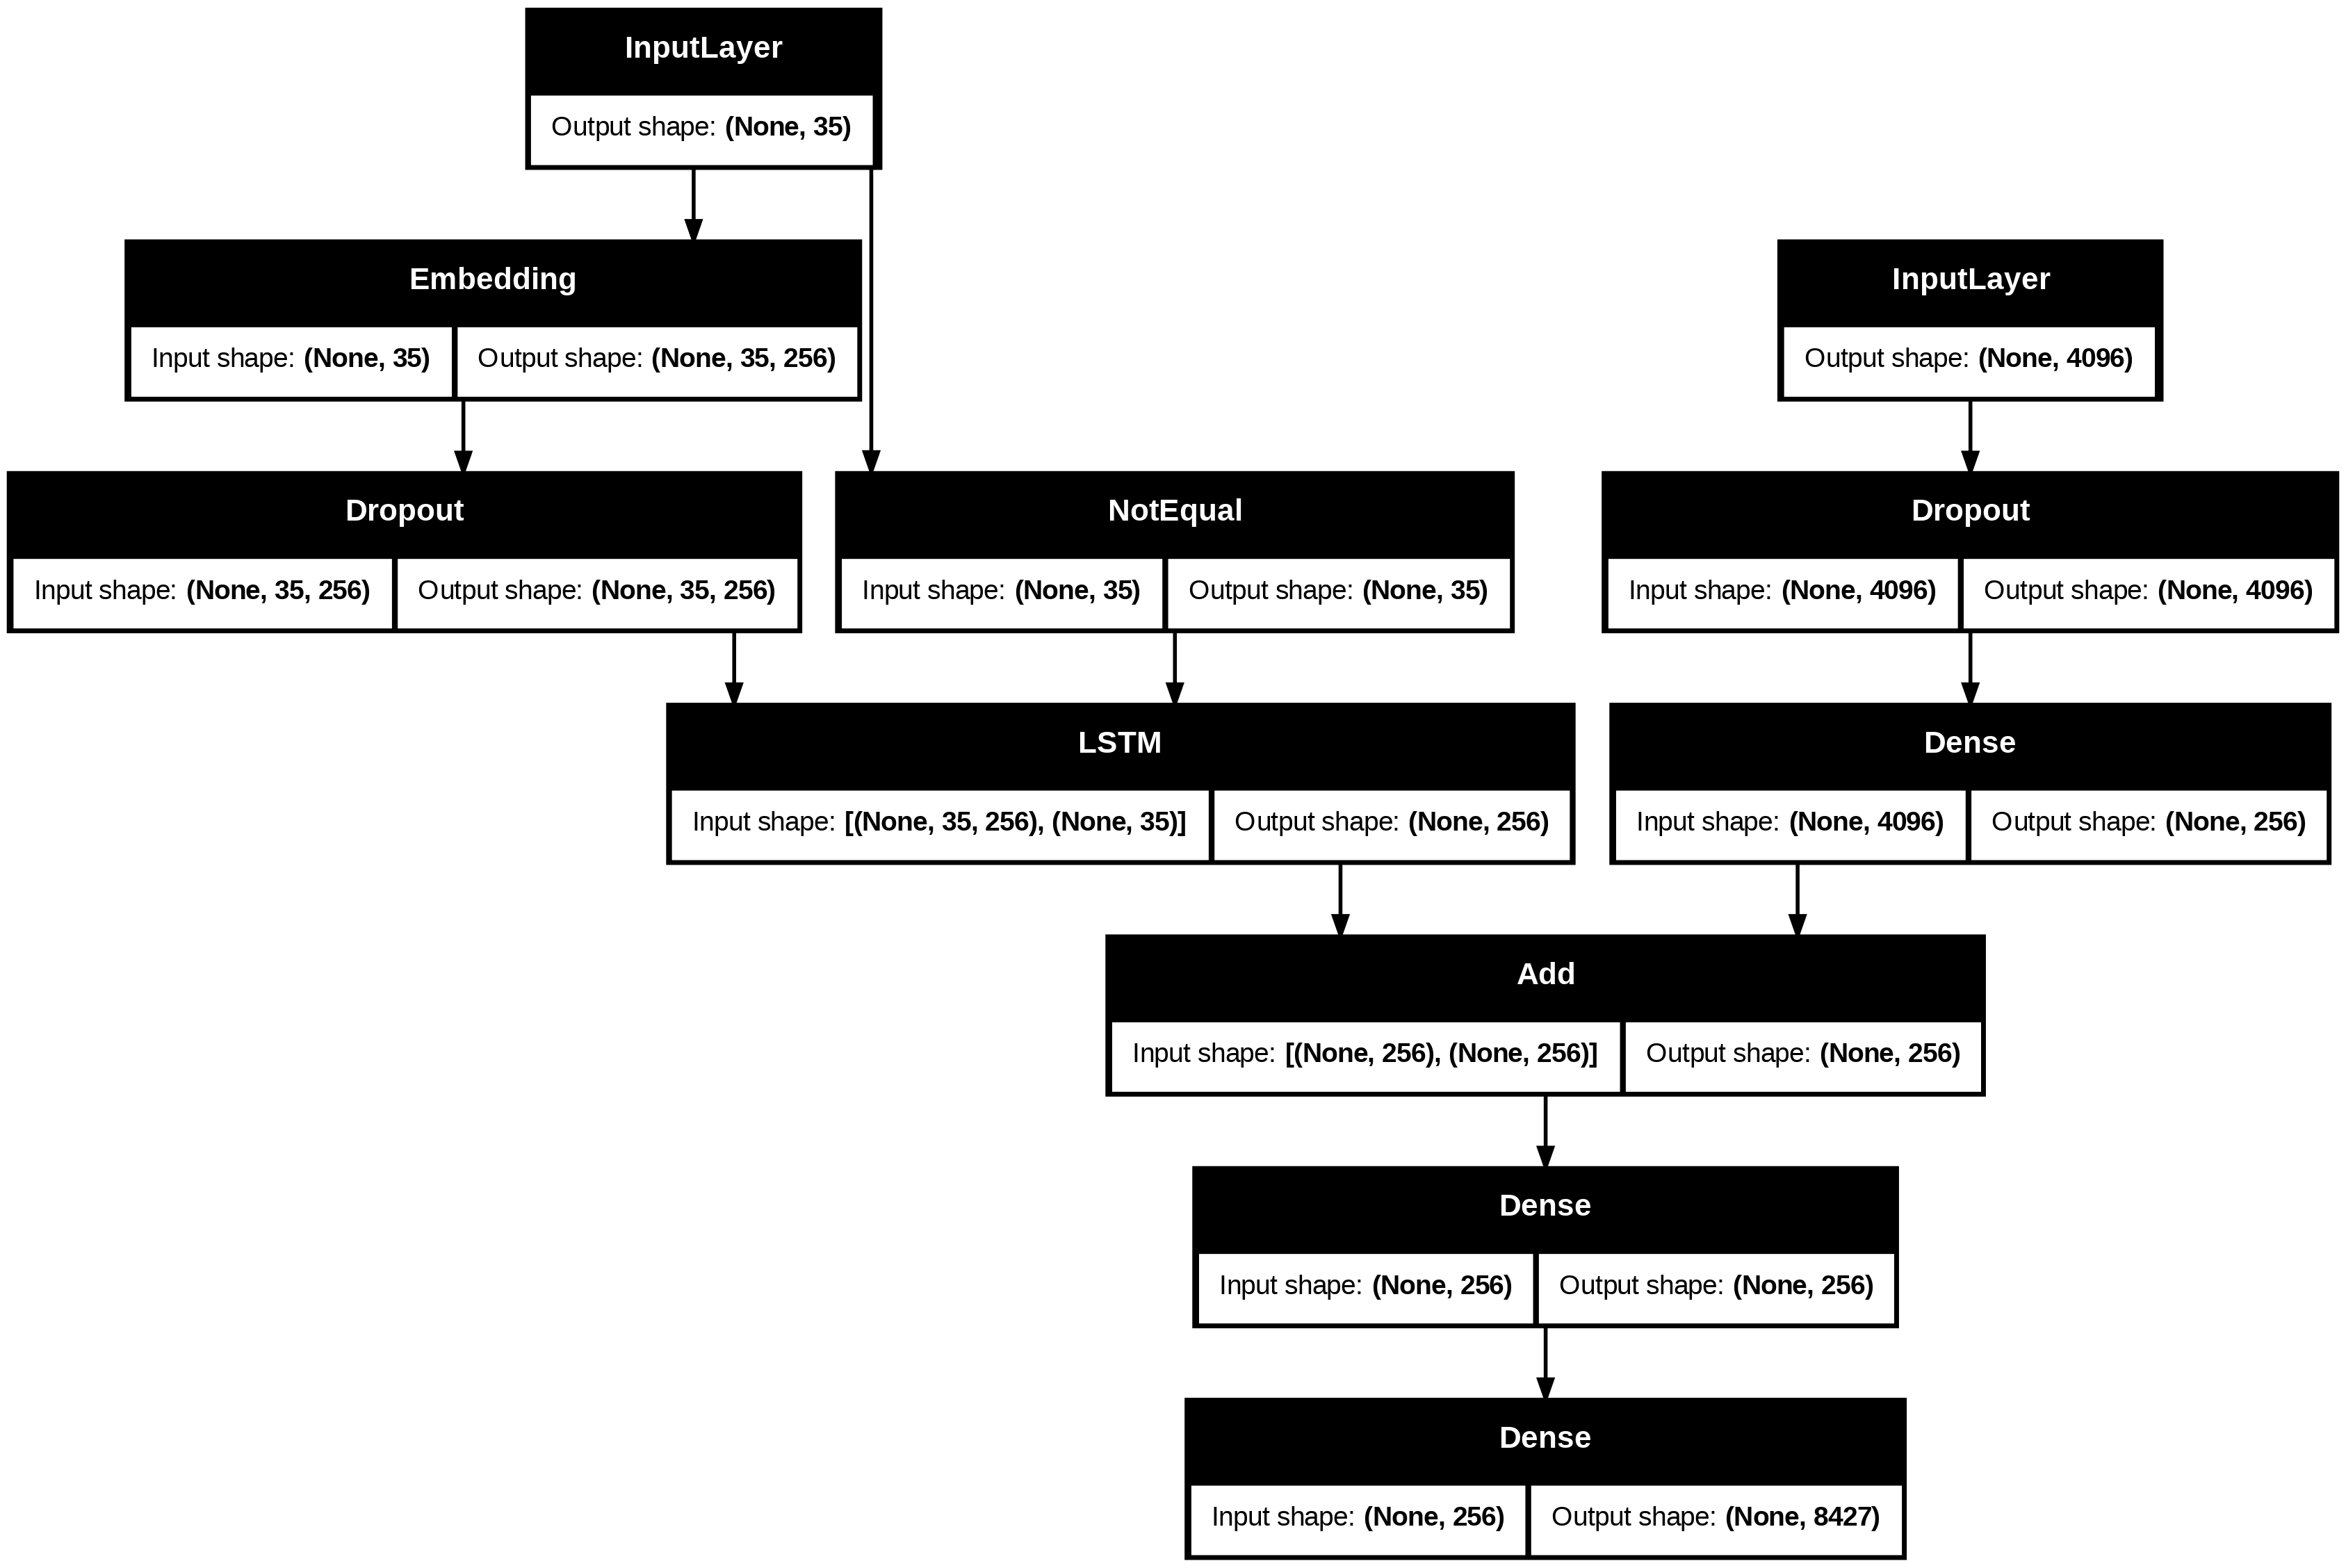

In [23]:
# Model Creation
# encoder model

# image feature layers
inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)


In [24]:
train = [key for key in train if key in features]
len(train)

7281

In [25]:
print(len(tokenizer.word_index))

8426


In [26]:
# train the model
epochs = 20
batch_size = 16
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

455/455 ━━━━━━━━━━━━━━━━━━━━ 81s 162ms/step - loss: 5.4692
,455/455 ━━━━━━━━━━━━━━━━━━━━ 73s 160ms/step - loss: 3.8978
,455/455 ━━━━━━━━━━━━━━━━━━━━ 73s 161ms/step - loss: 3.4722
,455/455 ━━━━━━━━━━━━━━━━━━━━ 73s 160ms/step - loss: 3.2002
,455/455 ━━━━━━━━━━━━━━━━━━━━ 74s 163ms/step - loss: 3.0005
,455/455 ━━━━━━━━━━━━━━━━━━━━ 73s 161ms/step - loss: 2.8546
,455/455 ━━━━━━━━━━━━━━━━━━━━ 75s 164ms/step - loss: 2.7489
,455/455 ━━━━━━━━━━━━━━━━━━━━ 74s 162ms/step - loss: 2.6537
,455/455 ━━━━━━━━━━━━━━━━━━━━ 74s 162ms/step - loss: 2.5717
,455/455 ━━━━━━━━━━━━━━━━━━━━ 73s 161ms/step - loss: 2.4992
,455/455 ━━━━━━━━━━━━━━━━━━━━ 74s 162ms/step - loss: 2.4370
,455/455 ━━━━━━━━━━━━━━━━━━━━ 73s 161ms/step - loss: 2.3791
,455/455 ━━━━━━━━━━━━━━━━━━━━ 74s 163ms/step - loss: 2.3367
,455/455 ━━━━━━━━━━━━━━━━━━━━ 72s 159ms/step - loss: 2.2954
,455/455 ━━━━━━━━━━━━━━━━━━━━ 73s 160ms/step - loss: 2.2551
,455/455 ━━━━━━━━━━━━━━━━━━━━ 74s 162ms/step - loss: 2.2196
,455/455 ━━━━━━━━━━━━━━━━━━━━ 74s 163ms/s

In [30]:
# save the model
model.save('best_model.h5')

In [31]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
          return word
    return None

In [32]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length, padding='post')
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text


In [33]:
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm

actual, predicted = [], []

for key in tqdm(test):
    # Get all reference captions (ground truth)
    references = [caption.split() for caption in mapping[key]]

    # Get the predicted caption
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    y_pred = y_pred.split()

    # Store references and prediction
    actual.append(references)
    predicted.append(y_pred)

# Calculate BLEU scores after the loop
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))     # unigram
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))   # bigram
print("BLEU-3: %f" % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))) # trigram
print("BLEU-4: %f" % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))) # 4-gram


100%|██████████| 810/810 [12:21<00:00,  1.09it/s]


BLEU-1: 0.526570
,BLEU-2: 0.299876
,BLEU-3: 0.215091
,BLEU-4: 0.105918


In [34]:
from PIL import Image
import matplotlib.pyplot as plt
import os

def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = f"/content/flickr8k/Images/{image_name}"  # ✅ Adjusted path

    image = Image.open(img_path)

    # Actual captions
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)

    # Predicted caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)

    # Show image
    plt.imshow(image)
    plt.axis("off")
    plt.show()


---------------------Actual---------------------
,startseq cyclist on neon yellow bike is airborne endseq
,startseq motorcyclist is attempting jump with another motorcyclist nearby as well as onlookers endseq
,startseq person in red white and blue jumpsuit flying through the air on yellow motorcycle endseq
,startseq person in midair on yellow motorcycle endseq
,startseq person on yellow dirt bike is taking jump endseq
,--------------------Predicted--------------------
,startseq person on dirt bike is riding dirt hill endseq


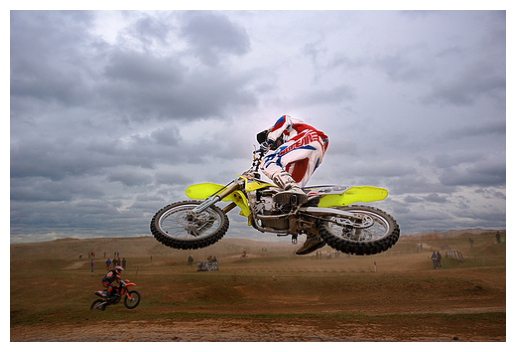

In [35]:
generate_caption("640053014_549d2f23d2.jpg")

---------------------Actual---------------------
,startseq woman playing an acoustic guitar with microphone endseq
,startseq woman singing and playing the acoustic guitar onstage endseq
,startseq woman sings into microphone while playing guitar endseq
,startseq young brown haired woman plays her guitar and sings into microphone endseq
,startseq young woman plays guitar and sings on stage endseq
,--------------------Predicted--------------------
,startseq man in blue shirt playing guitar endseq


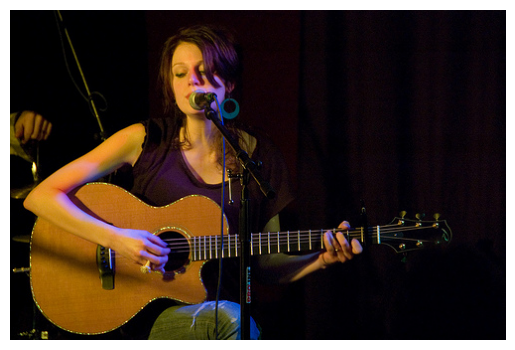

In [42]:
generate_caption("3197981073_3156963446.jpg")

---------------------Actual---------------------
,startseq boy in an orange jersey is about to pitch baseball endseq
,startseq boy in an orange spring hill ball team uniform pitching the ball endseq
,startseq little boy in orange pitching at baseball game endseq
,startseq young boy in an orange uniform is pitching baseball during game endseq
,startseq the boy in the orange shirt is throwing the ball endseq
,--------------------Predicted--------------------
,startseq baseball player in baseball uniform endseq


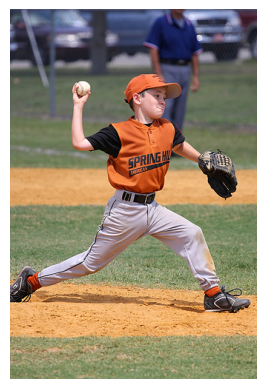

In [44]:
generate_caption("2562377955_8d670ccec6.jpg")

---------------------Actual---------------------
,startseq hiker treks up the snowy mountain endseq
,startseq man climbing snowy mountain endseq
,startseq man skiing in the mountains endseq
,startseq mountaineer is ascending snow covered trail whilst attached to rope endseq
,startseq person in blue hat climbing up snow covered mountain endseq
,--------------------Predicted--------------------
,startseq man is skiing down snowy mountain endseq


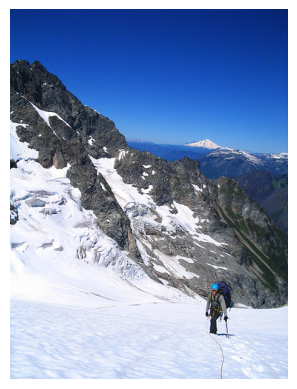

In [37]:
generate_caption("58363930_0544844edd.jpg")

---------------------Actual---------------------
,startseq black and white dog is jumping up to catch toy as another dog watches endseq
,startseq black and white dog jomps over another black and white dog to catch cloth frisbee endseq
,startseq black and white dog leaps for flying disc while another one watches endseq
,startseq the two dogs are playing catch with red frisbee endseq
,startseq the white dog with black spots is catching red frisbee endseq
,--------------------Predicted--------------------
,startseq dog is running along the beach endseq


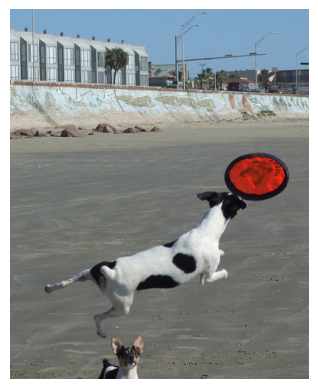

In [45]:
generate_caption("1436760519_8d6101a0ed.jpg")